In [0]:
#imports cell 
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Input,Flatten,GlobalAveragePooling2D,Dropout,InputLayer,GlobalAveragePooling3D,Reshape,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
K.set_image_data_format("channels_first")

### Mount the Google Drive to Google Colab

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Method for Loading dataset into Memory

In [0]:
def load_data(view,symptom,base_model,model_gap):
    train_X = np.load('/content/gdrive/My Drive/Dataset/Transformations/interpolated24_train_' + view + '.npy')
    valid_X = np.load('/content/gdrive/My Drive/Dataset/Transformations/interpolated24_valid_' + view + '.npy')
    train_Y = np.genfromtxt('/content/gdrive/My Drive/Dataset/MRNet-v1.0/train-' + symptom + '.csv',delimiter=',')[:,1]
    valid_Y = np.genfromtxt('/content/gdrive/My Drive/Dataset/MRNet-v1.0/valid-' + symptom + '.csv',delimiter=',')[:,1]
    train_X=np.stack([train_X]*3,axis=2)
    valid_X=np.stack([valid_X]*3,axis=2)
    
    ##feature extraction and passing data to GAP layer
    new_train_X = np.zeros(shape=(1130,24,512))
    for i in range(1130):
      first_output=base_model.predict(train_X[i])
      new_train_X[i] = model_gap.predict(first_output)
    train_X = None

    
    new_valid_X = np.zeros(shape=(120,24,512))
    for i in range(120):
      first_output=base_model.predict(valid_X[i])
      new_valid_X[i] = model_gap.predict(first_output)
    valid_X = None
    
    new_train_X=new_train_X.reshape(1130,512,24,1)
    new_valid_X=new_valid_X.reshape(120,512,24,1)
    return new_train_X,train_Y,new_valid_X,valid_Y
    

## Build Model

In [0]:
def build_model():
  #feature extractor
  base_model = VGG16(weights='imagenet',input_shape=(3,256,256),include_top=False,input_tensor=Input(shape=(3,256,256)))
  #Global Average Pooling
  inputs=Input(shape=(512,8,8))
  gap=GlobalAveragePooling2D()(inputs)
  model_gap=Model(inputs=inputs,outputs=gap)
  #Final Model
  inputs=Input(shape=(512,24,1))
  batch_norm = BatchNormalization()(inputs)
  max_pooling=MaxPooling2D(1,24)(batch_norm)
  flatten = Flatten()(max_pooling)
  model = Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001))(flatten)
  model = Dropout(0.5)(model)
  model = Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001))(model)
  model = Dropout(0.5)(model)
  pred = Dense(1,activation='sigmoid')(model)
  model_final=Model(inputs=inputs,outputs=pred)
  
  model_final.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
  return base_model,model_gap,model_final

def show_model(model):
  model.summary()
  
def train_model(plane,label):
  base_model,model_gap,model = build_model()
  train_X,train_y,val_X,val_y = load_data(plane,label,base_model,model_gap)
  class_weights = class_weight.compute_class_weight('balanced',np.unique(train_y),train_y)
  class_weights_dict = dict(enumerate(class_weights))
  val_sample_weights = class_weight.compute_sample_weight('balanced', val_y)
  mc = ModelCheckpoint('/content/gdrive/My Drive/Models/PaperImplementation/'+plane+'_'+label+'.h5', monitor='val_acc', mode='max', verbose=2, save_best_only=True)
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=5)
  history = model.fit(x=train_X, y=train_y,  validation_data=(val_X,val_y,val_sample_weights), batch_size = 20, epochs=50,verbose=2, callbacks=[mc,es], class_weight = class_weights_dict)
  return history


def plot_history(histories, key='acc'):
  plt.figure(figsize=(16,10))
  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val',color='b')
    plt.plot(history.epoch, history.history[key], color='b',
             label=name.title()+' Train')
  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()
  plt.ylim([0,1])
  plt.xlim([0,max(history.epoch)])
  plt.figure(0)
  plt.show()
  
  plt.figure(figsize=(16,10))
  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_loss'],
                   '--', label=name.title()+' Val',color='r')
    plt.plot(history.epoch, history.history['loss'], color='r',
             label=name.title()+' Train')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.ylim([0,1.5])
  plt.xlim([0,max(history.epoch)])
  plt.show()

# Let's Begin Training the Net

## Model 1: Axial Plane and ACL Labels

Train on 1130 samples, validate on 120 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50

Epoch 00001: val_acc improved from -inf to 0.68333, saving model to /content/gdrive/My Drive/Models/PaperImplementation/axial_acl.h5
 - 1s - loss: 0.9164 - acc: 0.5938 - val_loss: 0.7915 - val_acc: 0.6833
Epoch 2/50

Epoch 00002: val_acc did not improve from 0.68333
 - 0s - loss: 0.8303 - acc: 0.6257 - val_loss: 0.7717 - val_acc: 0.6417
Epoch 3/50

Epoch 00003: val_acc did not improve from 0.68333
 - 0s - loss: 0.7887 - acc: 0.6858 - val_loss: 0.7616 - val_acc: 0.6833
Epoch 4/50

Epoch 00004: val_acc did not improve from 0.68333
 - 0s - loss: 0.7929 - acc: 0.6584 - val_loss: 0.7554 - val_acc: 0.6583
Epoch 5/50

Epoch 00005: val_acc improved from 0.68333 to 0.70000, saving model to /content/gdrive/My Drive/Models/PaperImplementation/axial_acl.h5
 - 0s - loss: 0.7819 - acc: 0.6009 - val_loss: 0.7275 - val_acc: 0.7000
Epoch 6/50

Epoch 00006: val_acc did not improve from 0.70000
 - 0

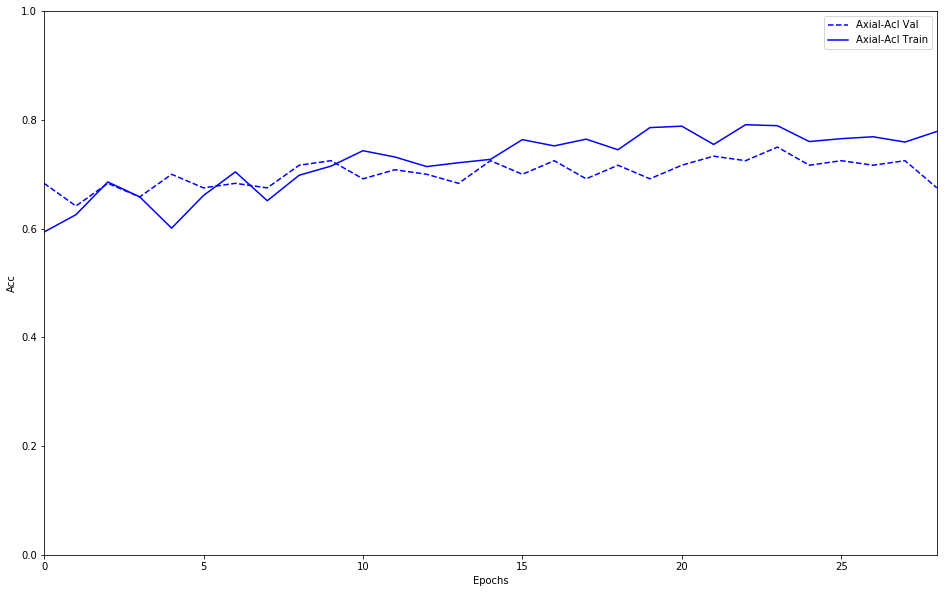

<Figure size 432x288 with 0 Axes>

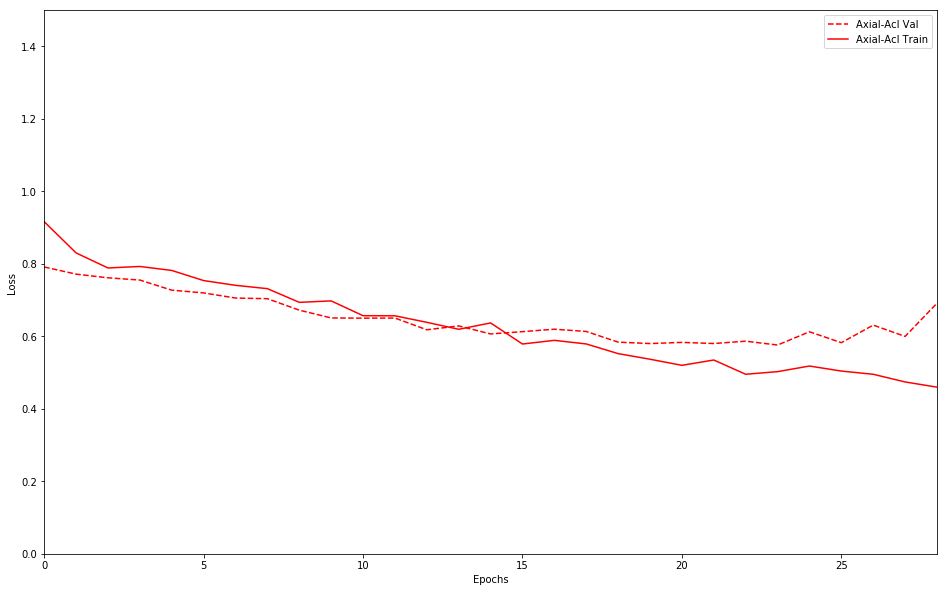

In [8]:
history = train_model("axial","acl")
plot_history([('Axial-ACL',history)])

## Model 2: Axial Plane and Abnormal Labels

Train on 1130 samples, validate on 120 samples
Epoch 1/50

Epoch 00001: val_acc improved from -inf to 0.79167, saving model to /content/gdrive/My Drive/Models/PaperImplementation/axial_abnormal.h5
 - 1s - loss: 0.9042 - acc: 0.6150 - val_loss: 1.2878 - val_acc: 0.7917
Epoch 2/50

Epoch 00002: val_acc improved from 0.79167 to 0.80833, saving model to /content/gdrive/My Drive/Models/PaperImplementation/axial_abnormal.h5
 - 0s - loss: 0.7922 - acc: 0.6991 - val_loss: 0.8715 - val_acc: 0.8083
Epoch 3/50

Epoch 00003: val_acc improved from 0.80833 to 0.82500, saving model to /content/gdrive/My Drive/Models/PaperImplementation/axial_abnormal.h5
 - 0s - loss: 0.7038 - acc: 0.7248 - val_loss: 0.8717 - val_acc: 0.8250
Epoch 4/50

Epoch 00004: val_acc did not improve from 0.82500
 - 0s - loss: 0.6275 - acc: 0.7894 - val_loss: 0.8844 - val_acc: 0.8167
Epoch 5/50

Epoch 00005: val_acc did not improve from 0.82500
 - 0s - loss: 0.6405 - acc: 0.7655 - val_loss: 0.7466 - val_acc: 0.8167
Epoch 6/50

E

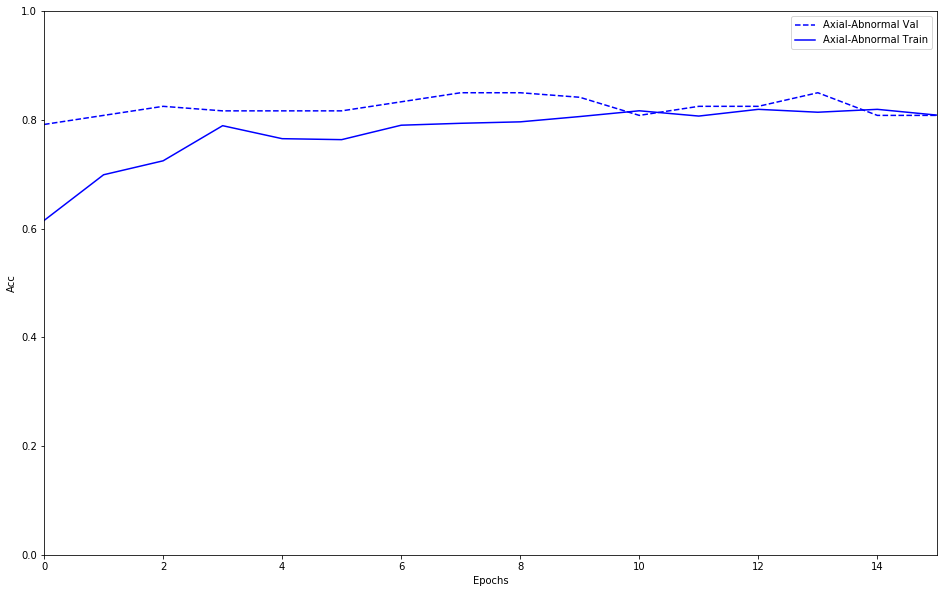

<Figure size 432x288 with 0 Axes>

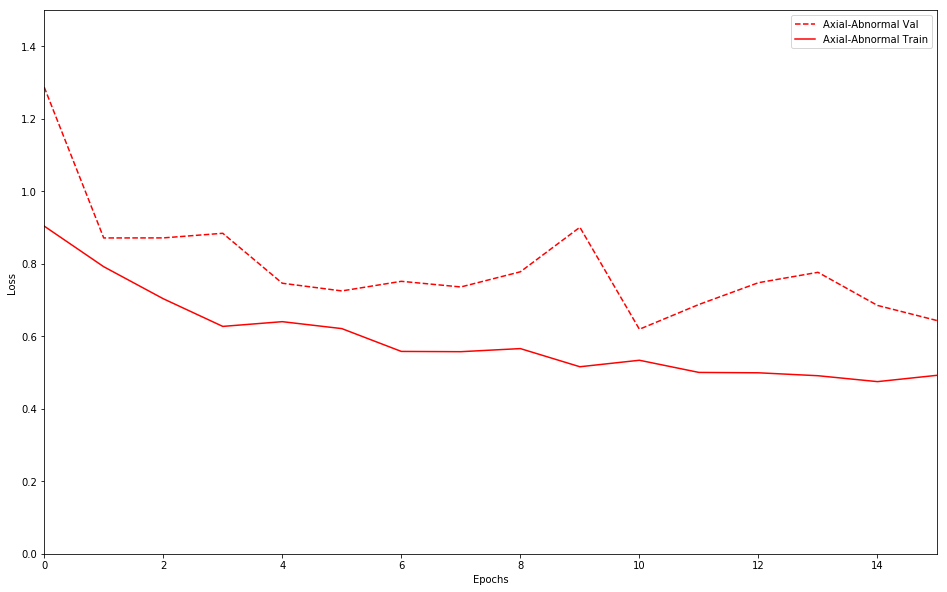

In [9]:
history = train_model("axial","abnormal")
plot_history([('Axial-Abnormal',history)])

## Model 3: Axial Plane and Meniscus Labels

Train on 1130 samples, validate on 120 samples
Epoch 1/50

Epoch 00001: val_acc improved from -inf to 0.48333, saving model to /content/gdrive/My Drive/Models/PaperImplementation/axial_meniscus.h5
 - 2s - loss: 0.9324 - acc: 0.5407 - val_loss: 0.8812 - val_acc: 0.4833
Epoch 2/50

Epoch 00002: val_acc improved from 0.48333 to 0.52500, saving model to /content/gdrive/My Drive/Models/PaperImplementation/axial_meniscus.h5
 - 0s - loss: 0.8132 - acc: 0.6035 - val_loss: 0.8351 - val_acc: 0.5250
Epoch 3/50

Epoch 00003: val_acc improved from 0.52500 to 0.56667, saving model to /content/gdrive/My Drive/Models/PaperImplementation/axial_meniscus.h5
 - 0s - loss: 0.7893 - acc: 0.6159 - val_loss: 0.7889 - val_acc: 0.5667
Epoch 4/50

Epoch 00004: val_acc improved from 0.56667 to 0.62500, saving model to /content/gdrive/My Drive/Models/PaperImplementation/axial_meniscus.h5
 - 0s - loss: 0.7647 - acc: 0.6549 - val_loss: 0.7707 - val_acc: 0.6250
Epoch 5/50

Epoch 00005: val_acc did not improve from 0.

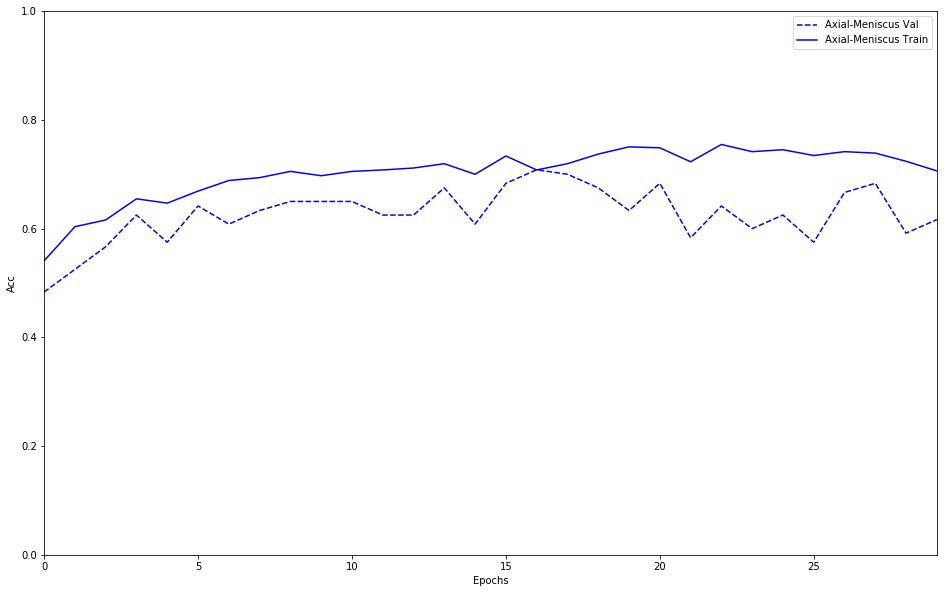

<Figure size 432x288 with 0 Axes>

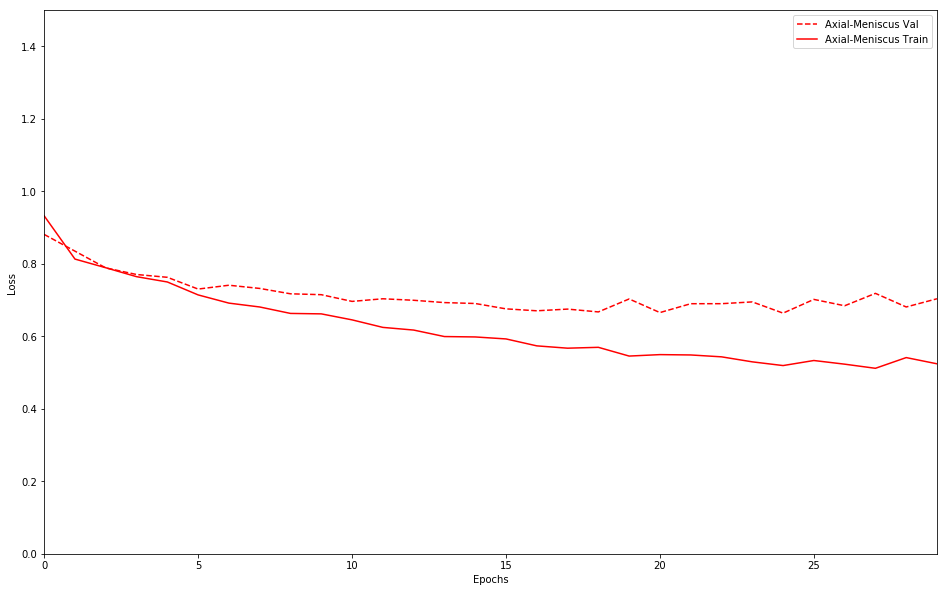

In [10]:
history = train_model("axial","meniscus")
plot_history([('Axial-Meniscus',history)])

## Model 4: Coronol Plane and ACL Labels

Train on 1130 samples, validate on 120 samples
Epoch 1/50

Epoch 00001: val_acc improved from -inf to 0.50000, saving model to /content/gdrive/My Drive/Models/PaperImplementation/coronal_acl.h5
 - 2s - loss: 1.0329 - acc: 0.5283 - val_loss: 0.8796 - val_acc: 0.5000
Epoch 2/50

Epoch 00002: val_acc improved from 0.50000 to 0.55000, saving model to /content/gdrive/My Drive/Models/PaperImplementation/coronal_acl.h5
 - 0s - loss: 0.8682 - acc: 0.5681 - val_loss: 0.8751 - val_acc: 0.5500
Epoch 3/50

Epoch 00003: val_acc improved from 0.55000 to 0.57500, saving model to /content/gdrive/My Drive/Models/PaperImplementation/coronal_acl.h5
 - 0s - loss: 0.8508 - acc: 0.6292 - val_loss: 0.8422 - val_acc: 0.5750
Epoch 4/50

Epoch 00004: val_acc did not improve from 0.57500
 - 0s - loss: 0.8360 - acc: 0.5478 - val_loss: 0.8356 - val_acc: 0.5167
Epoch 5/50

Epoch 00005: val_acc did not improve from 0.57500
 - 0s - loss: 0.8310 - acc: 0.6593 - val_loss: 0.8246 - val_acc: 0.5417
Epoch 6/50

Epoch 0000

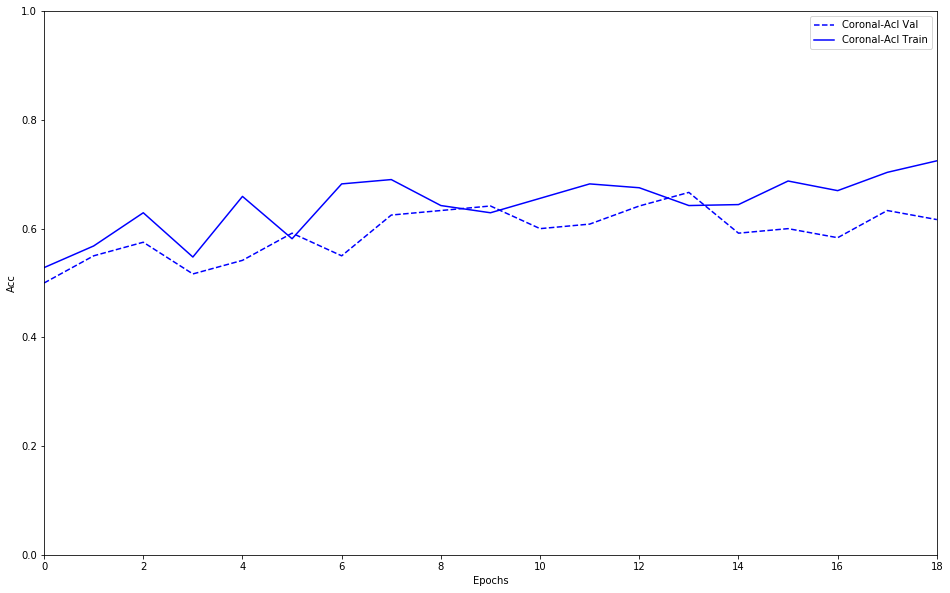

<Figure size 432x288 with 0 Axes>

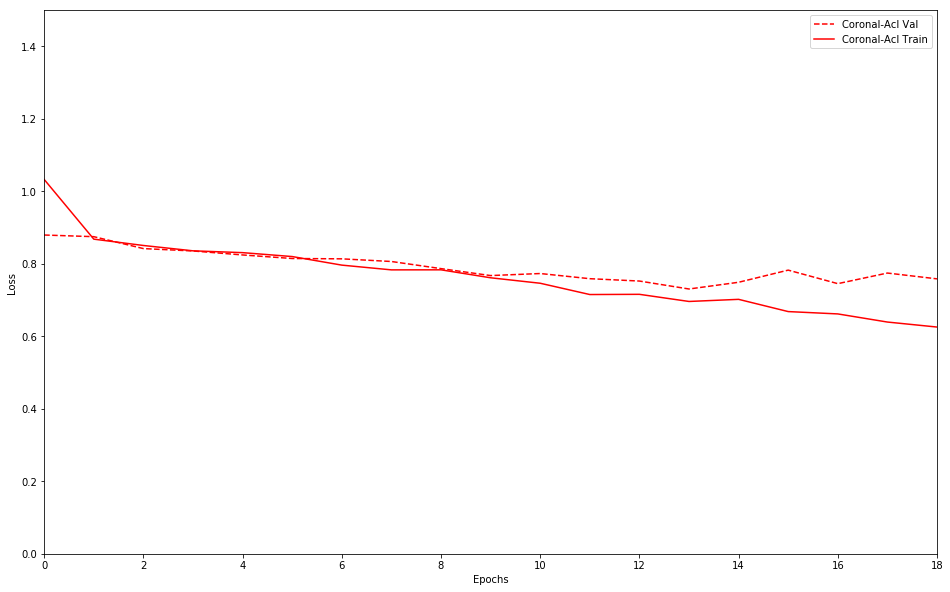

In [11]:
history = train_model("coronal","acl")
plot_history([('Coronal-ACL',history)])

## Model 5: Coronol Plane and Abnormal Labels

Train on 1130 samples, validate on 120 samples
Epoch 1/50

Epoch 00001: val_acc improved from -inf to 0.51667, saving model to /content/gdrive/My Drive/Models/PaperImplementation/coronal_abnormal.h5
 - 2s - loss: 0.9218 - acc: 0.6310 - val_loss: 0.8111 - val_acc: 0.5167
Epoch 2/50

Epoch 00002: val_acc improved from 0.51667 to 0.81667, saving model to /content/gdrive/My Drive/Models/PaperImplementation/coronal_abnormal.h5
 - 0s - loss: 0.8103 - acc: 0.6265 - val_loss: 0.8041 - val_acc: 0.8167
Epoch 3/50

Epoch 00003: val_acc did not improve from 0.81667
 - 0s - loss: 0.7524 - acc: 0.6920 - val_loss: 0.8034 - val_acc: 0.7833
Epoch 4/50

Epoch 00004: val_acc did not improve from 0.81667
 - 0s - loss: 0.7350 - acc: 0.7283 - val_loss: 0.7496 - val_acc: 0.7500
Epoch 5/50

Epoch 00005: val_acc did not improve from 0.81667
 - 0s - loss: 0.6977 - acc: 0.7186 - val_loss: 0.7818 - val_acc: 0.7750
Epoch 6/50

Epoch 00006: val_acc did not improve from 0.81667
 - 0s - loss: 0.6813 - acc: 0.7239 - v

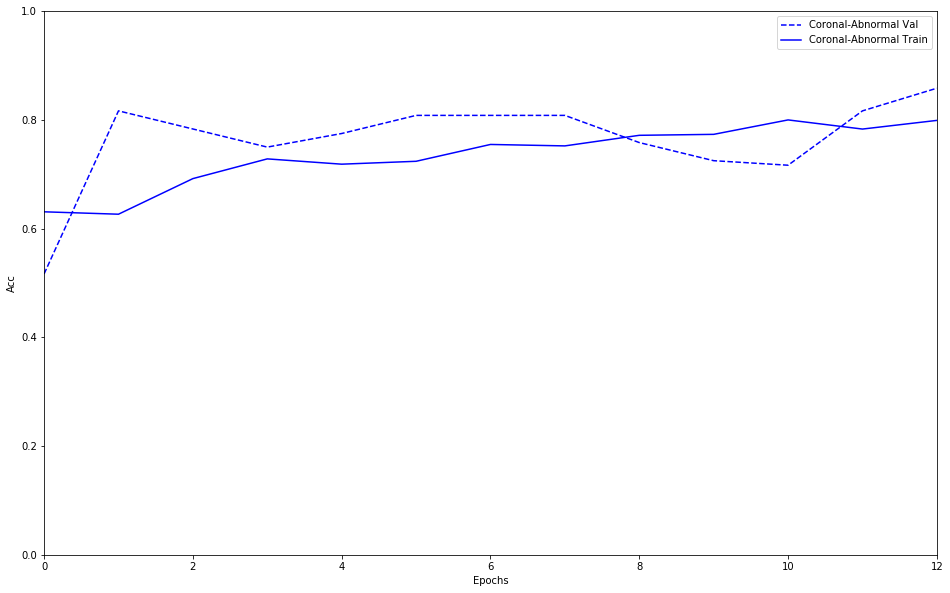

<Figure size 432x288 with 0 Axes>

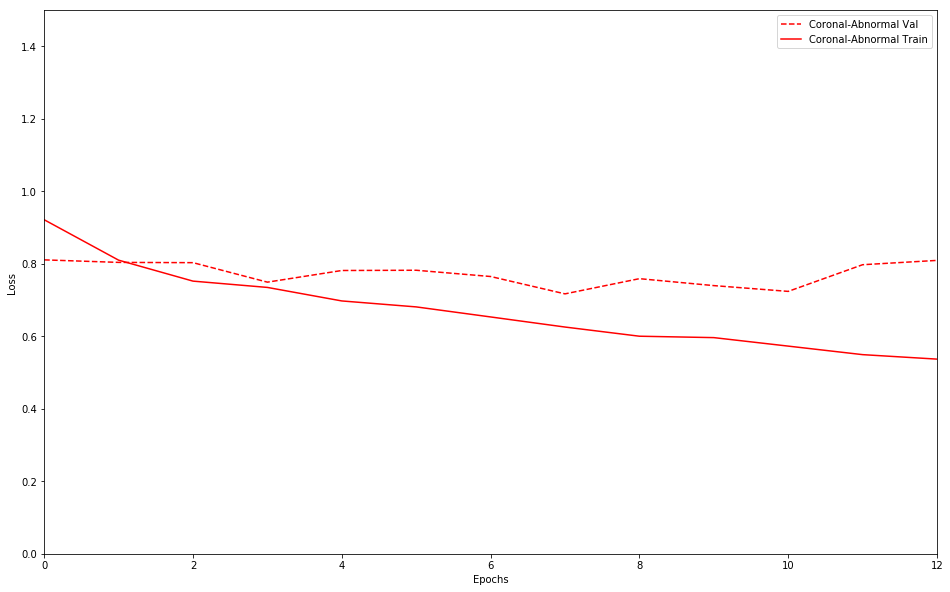

In [12]:
history = train_model("coronal","abnormal")
plot_history([('Coronal-Abnormal',history)])

## Model 6: Coronol Plane and Meniscus Labels

Train on 1130 samples, validate on 120 samples
Epoch 1/50

Epoch 00001: val_acc improved from -inf to 0.63333, saving model to /content/gdrive/My Drive/Models/PaperImplementation/coronal_meniscus.h5
 - 2s - loss: 0.9526 - acc: 0.5319 - val_loss: 0.8067 - val_acc: 0.6333
Epoch 2/50

Epoch 00002: val_acc did not improve from 0.63333
 - 0s - loss: 0.8434 - acc: 0.5805 - val_loss: 0.8036 - val_acc: 0.6000
Epoch 3/50

Epoch 00003: val_acc improved from 0.63333 to 0.64167, saving model to /content/gdrive/My Drive/Models/PaperImplementation/coronal_meniscus.h5
 - 0s - loss: 0.8130 - acc: 0.5938 - val_loss: 0.7878 - val_acc: 0.6417
Epoch 4/50

Epoch 00004: val_acc improved from 0.64167 to 0.65000, saving model to /content/gdrive/My Drive/Models/PaperImplementation/coronal_meniscus.h5
 - 0s - loss: 0.7853 - acc: 0.6142 - val_loss: 0.7518 - val_acc: 0.6500
Epoch 5/50

Epoch 00005: val_acc did not improve from 0.65000
 - 0s - loss: 0.7644 - acc: 0.6257 - val_loss: 0.7455 - val_acc: 0.6333
Epoch 6

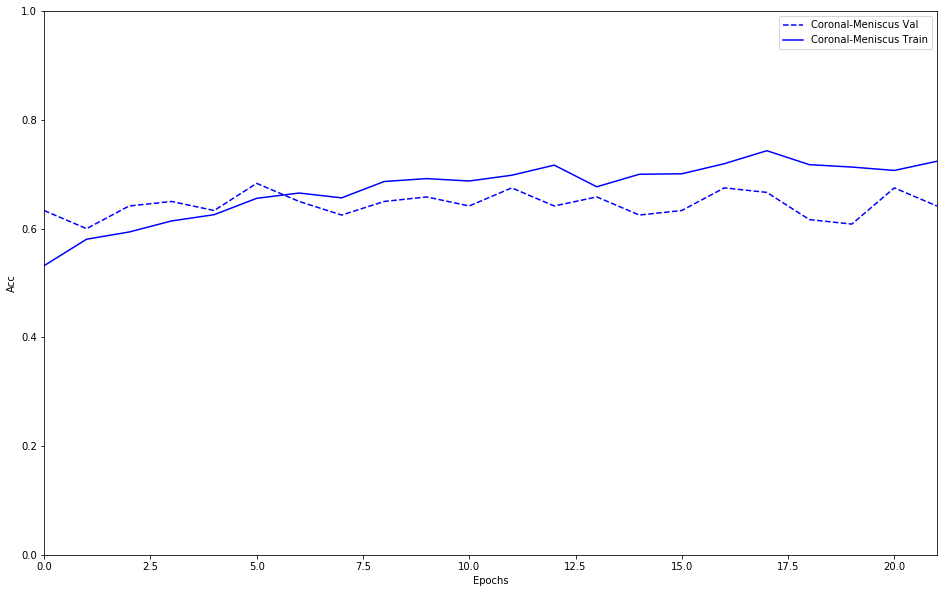

<Figure size 432x288 with 0 Axes>

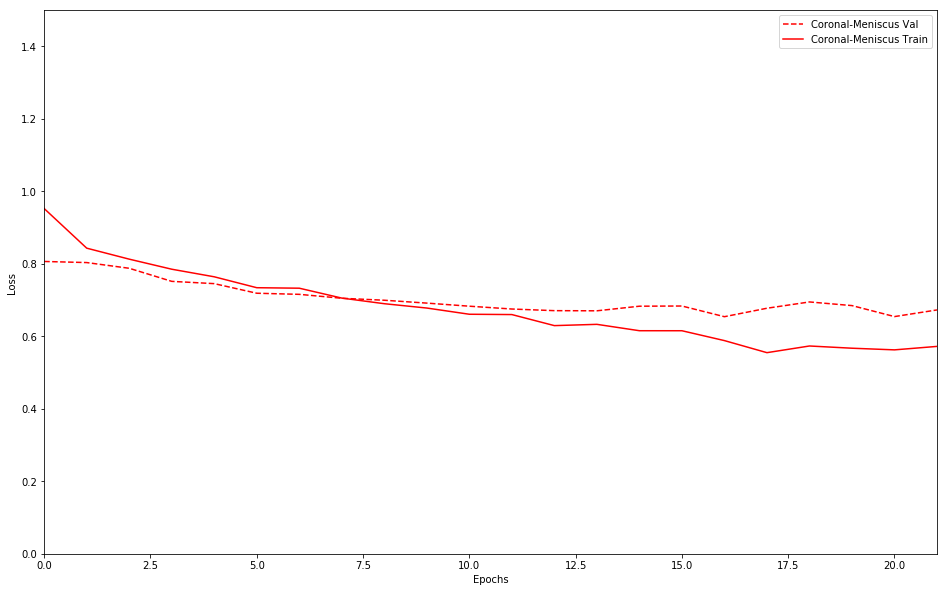

In [13]:
history = train_model("coronal","meniscus")
plot_history([('Coronal-Meniscus',history)])

## Model 7: Sagittal Plane and ACL Labels

Train on 1130 samples, validate on 120 samples
Epoch 1/50

Epoch 00001: val_acc improved from -inf to 0.58333, saving model to /content/gdrive/My Drive/Models/PaperImplementation/sagittal_acl.h5
 - 2s - loss: 0.9210 - acc: 0.5929 - val_loss: 0.8575 - val_acc: 0.5833
Epoch 2/50

Epoch 00002: val_acc improved from 0.58333 to 0.69167, saving model to /content/gdrive/My Drive/Models/PaperImplementation/sagittal_acl.h5
 - 0s - loss: 0.8696 - acc: 0.6124 - val_loss: 0.8135 - val_acc: 0.6917
Epoch 3/50

Epoch 00003: val_acc did not improve from 0.69167
 - 0s - loss: 0.8429 - acc: 0.5867 - val_loss: 0.8102 - val_acc: 0.6250
Epoch 4/50

Epoch 00004: val_acc did not improve from 0.69167
 - 0s - loss: 0.8294 - acc: 0.5867 - val_loss: 0.7855 - val_acc: 0.6917
Epoch 5/50

Epoch 00005: val_acc did not improve from 0.69167
 - 0s - loss: 0.7975 - acc: 0.6389 - val_loss: 0.7641 - val_acc: 0.6833
Epoch 6/50

Epoch 00006: val_acc improved from 0.69167 to 0.70000, saving model to /content/gdrive/My Drive/

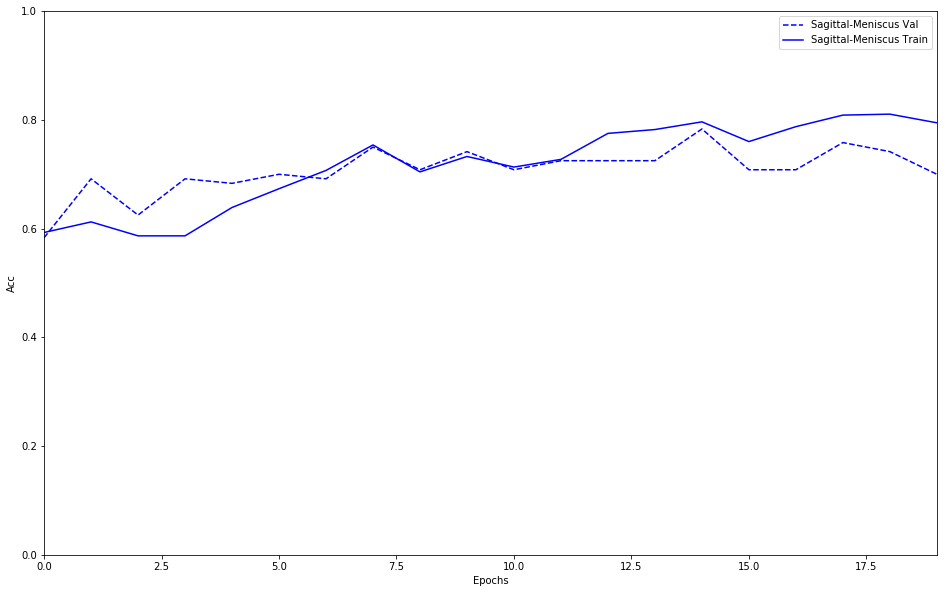

<Figure size 432x288 with 0 Axes>

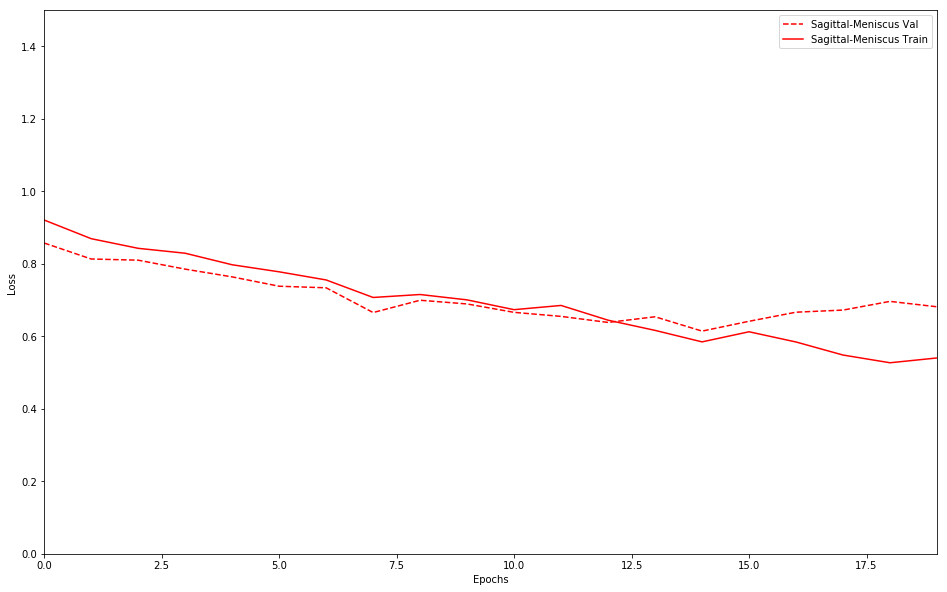

In [14]:
history = train_model("sagittal","acl")
plot_history([('Sagittal-Meniscus',history)])

## Model 8: Sagittal Plane and Abnormal Labels

Train on 1130 samples, validate on 120 samples
Epoch 1/50

Epoch 00001: val_acc improved from -inf to 0.82500, saving model to /content/gdrive/My Drive/Models/PaperImplementation/sagittal_abnormal.h5
 - 3s - loss: 0.9295 - acc: 0.6035 - val_loss: 0.8081 - val_acc: 0.8250
Epoch 2/50

Epoch 00002: val_acc did not improve from 0.82500
 - 0s - loss: 0.7968 - acc: 0.7221 - val_loss: 0.7440 - val_acc: 0.7667
Epoch 3/50

Epoch 00003: val_acc did not improve from 0.82500
 - 0s - loss: 0.7583 - acc: 0.7283 - val_loss: 0.6931 - val_acc: 0.7667
Epoch 4/50

Epoch 00004: val_acc improved from 0.82500 to 0.83333, saving model to /content/gdrive/My Drive/Models/PaperImplementation/sagittal_abnormal.h5
 - 0s - loss: 0.7343 - acc: 0.7265 - val_loss: 0.6616 - val_acc: 0.8333
Epoch 5/50

Epoch 00005: val_acc did not improve from 0.83333
 - 0s - loss: 0.7328 - acc: 0.7522 - val_loss: 0.6459 - val_acc: 0.8083
Epoch 6/50

Epoch 00006: val_acc did not improve from 0.83333
 - 0s - loss: 0.6727 - acc: 0.7655 -

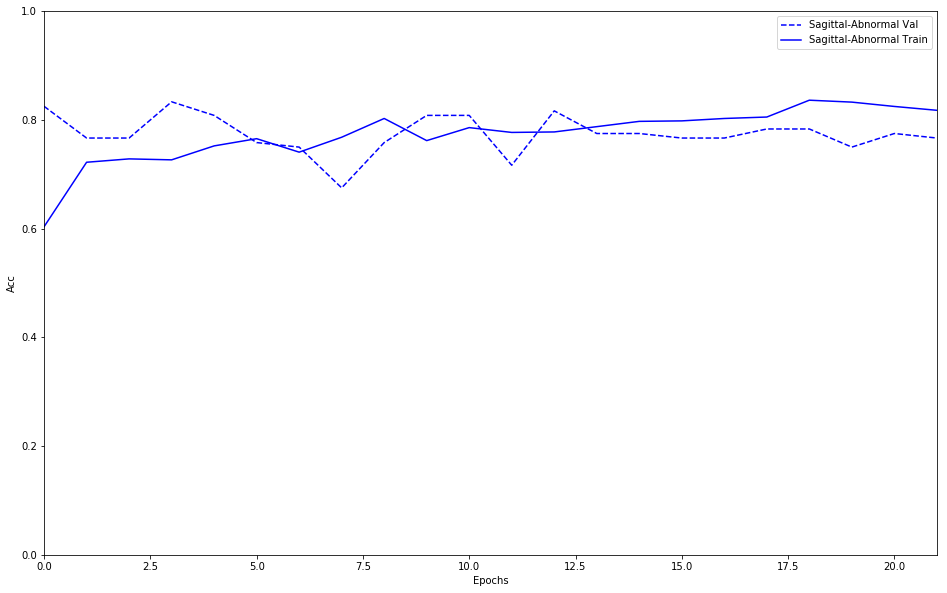

<Figure size 432x288 with 0 Axes>

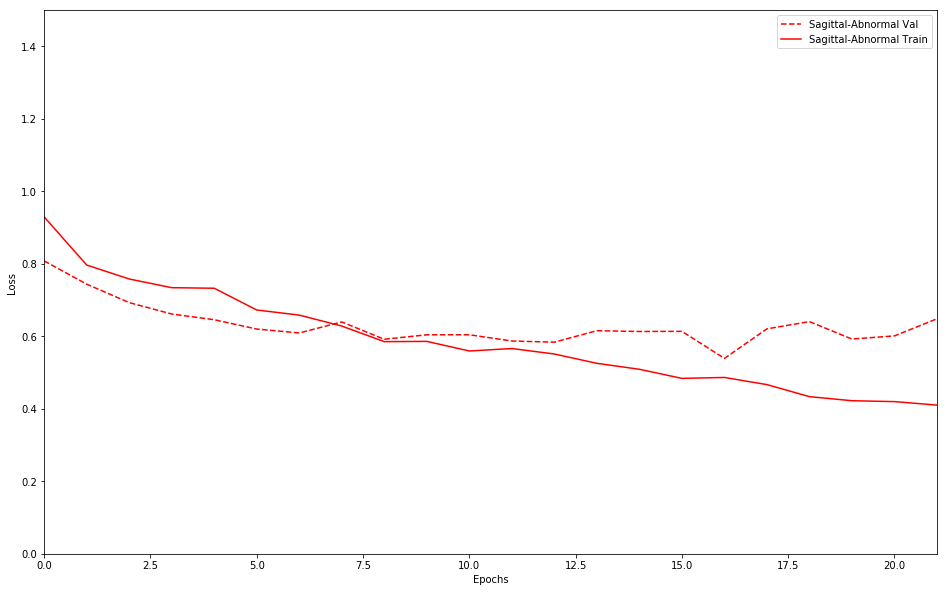

In [15]:
history = train_model("sagittal","abnormal")
plot_history([('Sagittal-Abnormal',history)])

## Model 9: Sagittal Plane and Meniscus Labels

Train on 1130 samples, validate on 120 samples
Epoch 1/50

Epoch 00001: val_acc improved from -inf to 0.53333, saving model to /content/gdrive/My Drive/Models/PaperImplementation/sagittal_meniscus.h5
 - 3s - loss: 0.9378 - acc: 0.5292 - val_loss: 0.8400 - val_acc: 0.5333
Epoch 2/50

Epoch 00002: val_acc improved from 0.53333 to 0.69167, saving model to /content/gdrive/My Drive/Models/PaperImplementation/sagittal_meniscus.h5
 - 0s - loss: 0.8456 - acc: 0.5496 - val_loss: 0.8033 - val_acc: 0.6917
Epoch 3/50

Epoch 00003: val_acc did not improve from 0.69167
 - 0s - loss: 0.8167 - acc: 0.5726 - val_loss: 0.7920 - val_acc: 0.6750
Epoch 4/50

Epoch 00004: val_acc did not improve from 0.69167
 - 0s - loss: 0.7870 - acc: 0.6212 - val_loss: 0.7883 - val_acc: 0.6167
Epoch 5/50

Epoch 00005: val_acc did not improve from 0.69167
 - 0s - loss: 0.7592 - acc: 0.6186 - val_loss: 0.7463 - val_acc: 0.6917
Epoch 6/50

Epoch 00006: val_acc did not improve from 0.69167
 - 0s - loss: 0.7421 - acc: 0.6655 -

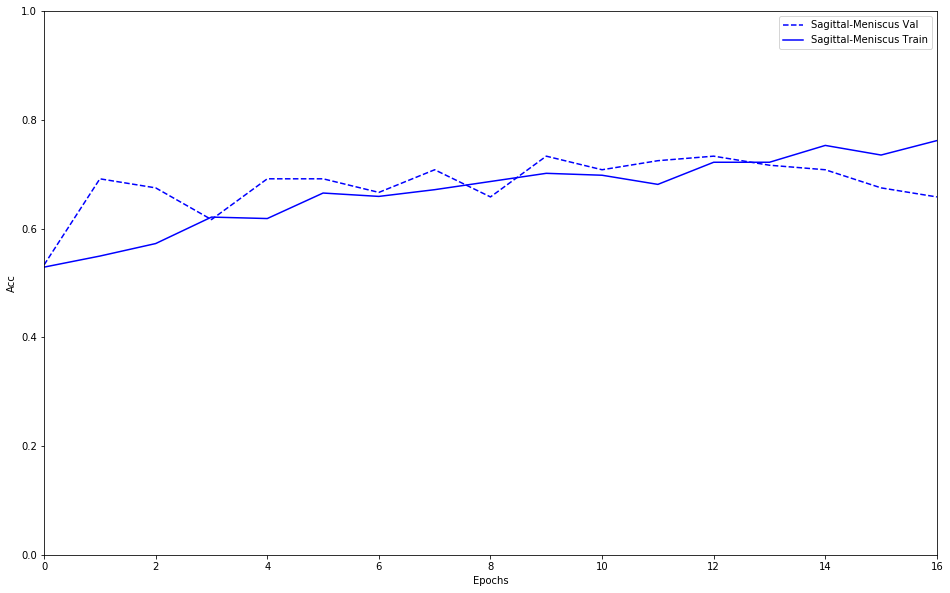

<Figure size 432x288 with 0 Axes>

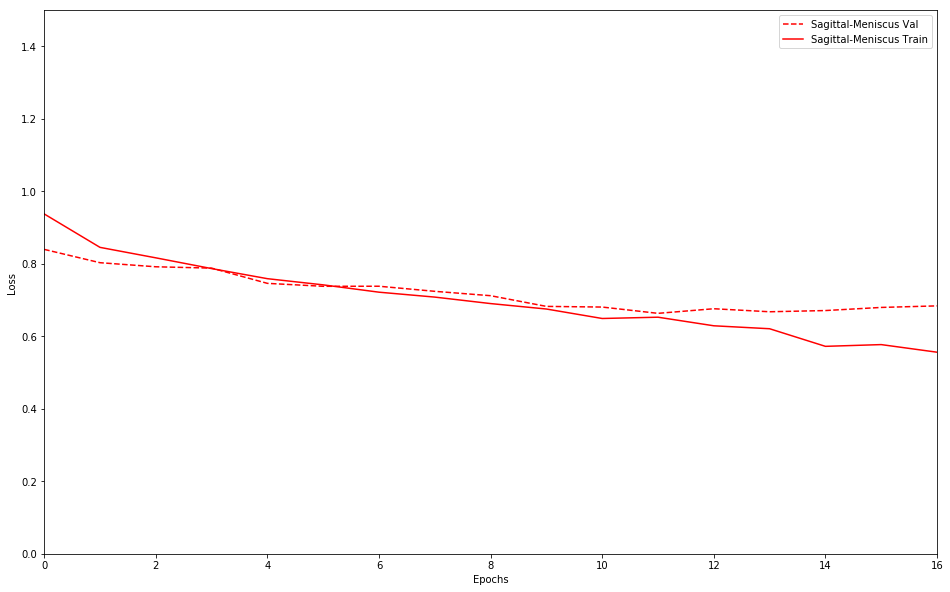

In [16]:
history = train_model("sagittal","meniscus")
plot_history([('Sagittal-Meniscus',history)])